# CS6133_Project_2_Report <br>
Joh Eun Kang (jk5726)<br>
Dinesh Sreekanthan (ds5786)<br>


# __Project Title:<br>__
Gradient Episodic Momory with rotated MNIST data set.

# __Motivation:__<br>
In training machine learning model, we are often faced with difficulties of re-training the entire data every time we get updated data. This process would not be a big deal if the data is small enough to train all over again. However, since we often deal with large amounts of data, re-training would not be effiecent way to train the machine. <br>

So, people came up with the new term called __"Machine Intelligence"__.<br>
 
There are sigificant differences between machines and humans in terms of learning.  When a machine learns new data, they only remember the most current learning experience, not the history of their learning experiences. (previous task, current task). <br>

However, when human learn new things, we still remember some of previous learning experinece. Even though we forget some of the old memories over time, but we don't forget the entire experience at once. Also, we often use those expeiences for our current or next learning more efficently!<br> 


#__Project Purpose__:

The goal of continual learning is to try applying such a person's learning method on the machines. There are several ways to to measure the performace of the model in terms of CL such as  measuring __backward transfer__ and __forward transfer__ rate. <br>

__Backward transfer (BWT):__ is the influence that learning a current task has on the performance on a previous task.<br>
-  positive backward transfer: when learning about some task t increases the performance on some preceding task k.<br>
- negative backward transfer when learning about some task t decreases the performance on some preceding task k. (Large negative backward transfer: __catastrophic forgetting.__)<br>

__Forward transfer(FWT):__ is the influence that learning a taskt has on the performance on a future task k ≻ t. <br>
- positive forward transfer__: possible when the model is able to perform “zero-shot” learning, perhaps by exploiting the structure available in the task descriptors.<br>

In this project, we focused more on understading backward transfer, and more specifically  __"Catastrophic forgetting"__.

# __Alrogithm Used:__ Gradient Episodic Memory.

#__Procedure:__

## 1. MNIST data set<br>
The MNIST database, known as Modified National Institute of Standards and Technology database, is a large database of handwritten digits. We take a look at a variation of MNIST known as *mnist-rot*, where the digits are rotated by an angle between 0 and 2π. This means the important factor involved is the rotation angle.<br><br> 


 In this section, we are going to see the actual image of data set and how the image is rotated. Rotation angle depends on how we set the angle in the 3rd cell of this section. 

### - Download the data 
```python
mnist_path = "mnist.npz"

if not os.path.exists(mnist_path):
    subprocess.call("wget https://s3.amazonaws.com/img-datasets/mnist.npz", shell=True)

def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

f = np.load('mnist.npz')
x_tr = torch.from_numpy(f['x_train'])
y_tr = torch.from_numpy(f['y_train']).long()
x_te = torch.from_numpy(f['x_test'])
y_te = torch.from_numpy(f['y_test']).long()
f.close()

torch.save((x_tr, y_tr), 'mnist_train.pt')
torch.save((x_te, y_te), 'mnist_test.pt')
```


### - Data rotation function
```python
def rotate_dataset(d, rotation):
    result = torch.FloatTensor(d.size(0), 784)
    tensor = transforms.ToTensor()

    for i in range(d.size(0)):
        img = Image.fromarray(d[i].numpy(), mode='L')
        result[i] = tensor(img.rotate(rotation)).view(784)
    return result
```
since each image is size of (28,28), we are __flatten the pixel to 28*28 = 784__

```python
n_tasks = 20  #number of tasks,
min_rot = 0  #minimum rotation,
max_rot = 180 #maximum rotation
seed = 0  #random seed

tasks_tr = []
tasks_te = []

x_tr, y_tr = torch.load('/content/mnist_train.pt') #data is tuple
x_te, y_te = torch.load('/content/mnist_test.pt')

for t in range(n_tasks):
    min_rot = 1.0 * t / n_tasks * (max_rot - min_rot) + \
        min_rot
    max_rot = 1.0 * (t + 1) / n_tasks * \
        (max_rot - min_rot) + min_rot
    rot = random.random() * (max_rot - min_rot) + min_rot

    tasks_tr.append([rot, rotate_dataset(x_tr, rot), y_tr])
    tasks_te.append([rot, rotate_dataset(x_te, rot), y_te])

torch.save([tasks_tr, tasks_te], 'mnist_rotations.pt') # make 'mnist_rotation.pt
```

### - Rotated data visualization

Structure of tasks (task1,,,,task20) are  <br>
train = [[angle1,image(60000), label],[angle2,image(60000), label],,,,[angle20,image(60000), label]]<br>
test =[[angle1,image(60000), label],[angle2,image(60000), label],,,,[angle20,image(60000), label]]<br>

```python
mrotation = torch.load('/content/mnist_rotations.pt')

# first image of 1st task
tensor_matrix_0 = mrotation[0][0][1]
# first image of 2nd task
tensor_matrix_1 = mrotation[0][1][1]
# first image of 3rd task
tensor_matrix_2 = mrotation[0][2][1]
# first image of 4th task
tensor_matrix_3 = mrotation[0][3][1]

plt.figure()
f, axarr = plt.subplots(1,4,figsize=(15, 10)) 
axarr[0].imshow(tensor_matrix_0[0].reshape(28,28), cmap="gray")
axarr[1].imshow(tensor_matrix_1[0].reshape(28,28), cmap="gray")
axarr[2].imshow(tensor_matrix_2[0].reshape(28,28), cmap="gray")
axarr[3].imshow(tensor_matrix_3[0].reshape(28,28), cmap="gray")
```


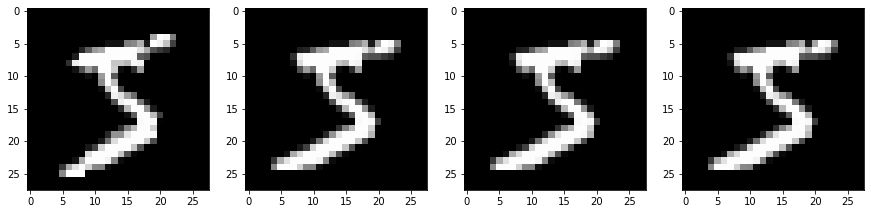

As we can see from above pictures, __pictures are rotated!__

## 2. Understanding Math behind the  GEM <br>


*@ David Lopez-Paz and Marc’Aurelio Ranzato
Facebook Artificial Intelligence Research* <br>

pesudo code for Training a GEM over an ordered continuum of data

```python
TRAIN(fθ,Continuumtrain,Continuumtest) 
Mt ←{}forallt=1,...,T.
for (x, y) in Continuumtrain(t) do Mt←Mt∪(x,y) g←∇θl(fθ(x,t),y)
gk ← ∇θ l(fθ, Mk) for all k < t
g ̃ ← PROJECT(g, g1, . . . , gt−1), see (11). θ ← θ − αg ̃.
end for
Rt,: ← EVALUATE(fθ,Continuumtest) end for
return fθ , R end procedure


EVALUATE(fθ,Continuum) 
r←0∈RT
R ← 0 ∈ R
for t = 1,...,T do:
T×T
for
k = 1, . . . , T do
rk ← 0
for (x, y) in Continuum(k) do
rk ←rk+accuracy(fθ(x,k),y) end for
.
rk ← rk / len(Continuum(k)) end for
return r end procedure
```

This procedure requires some optimization solving skills.<br>

Code in cell below is the actual code that uses __quadratic programming solving__. <br>

In this part, we are focusing math behind it .<br>

As we mentioned in the inroduction, we are focusing on the positive backward transformation. So, we use inequality contrainst of optimization. The inequality contraint will avoid increasing the loss but allowing their decrease. (minimizing loss, subject to some contraints). <br>

$minimize_θ \ \ L(f_θ (x, t), y)$<br>
subject to    $L(fθ, M_k) ≤ L(f_{t−1}, M_k)$ for all $k < t$ <br>

$f_{θ}^{t-1}$ is the predictor state at the end of learning of task $t − 1$.<br><br>



From this equation, we know that if the preceding taks loss does not increase after the parameter update, we do not need to store old predictors. 

Also, we assume that the function is locally linear and the memory is representative of the examples from past tasks, we know the increases of loss of previous tasks by computing the angle between thier loss gradient vector and update it.<br>

$<g,g_k> := < dL(f_{\theta}(x,t),y)/d\theta , dL(f_{theta},M_k)/d\theta> \ \geq \ 0$ for all $k,t$ <br>

If the inequality constraints are satisfied, it implies the proposed parameter update $g$ is not likely to increase the loss at the previous tasks. However, if at least one of those constraints are violated, then there is at least one previous task that would experience an increase in loss after the parameter update. <br>

This is same as solving quadratic programming <br>


$minimize_{g ̃} 1/2 \  ∥g − g ̃∥_2^2 $<br>
subject to $⟨g ̃,g_k⟩ ≥ 0$  for all $k < t.$<br>
$g$ = proposed gradient<br>
$g~$ = closest gradient<br>

$minimize (1/2)z⊤Cz + p⊤z$<br>
subject to $Az ≥ b$,<br>  
where $C \in R^{p*p}, p \in R^p, A \in R^{(t-1)*p}, and b \in R^{t-1}$ <br>

Then, we need to make the primal to  dual problem and solve the quadratic programming. <br>

$minimize_{u,v} (1/2)*u^TCu-b^Tv$<br>
$subject to A^Tv-Cu = p$<br>
$v \geq 0$

Assume that (u^*,v^*) is the optimal solution for above equation. Then ehre is a optimal z^* that satisfying Cz^* = Cu^*.<br>

Then, we can write the primal GEM quadratic programming equation <br>
$minimize (1/2)z⊤z − g⊤z + (1/2)g⊤g$ <br>
$subject to Gz \geq 0$ <br> 
$where G = 0(g_1,...,g_{t-1}$.<br>

Since the $g^Tg$ is constant, we can remove it.


__Finally__,<br>
we get <br>

$minimize (1/2)v^⊤GG^⊤v + g^⊤G^⊤v$ <br>
$subject \ to \ v \geq 0,$ <br>

here, $u = G^Tv$ +g and $g^Tg$ is constant, and this is quadratic programming on the number of observed tasks so far. Once we solve this dual problem for $v^*$, we recover the projected gradient update $g ̃= G^Tv^* + g$.<br>











```python
def project2cone2(gradient, memories, margin=0.5, eps=1e-3):
    memories_np = memories.cpu().t().double().numpy()
    gradient_np = gradient.cpu().contiguous().view(-1).double().numpy()
    t = memories_np.shape[0]
    P = np.dot(memories_np, memories_np.transpose())
    P = 0.5 * (P + P.transpose()) + np.eye(t) * eps
    q = np.dot(memories_np, gradient_np) * -1
    G = np.eye(t)
    h = np.zeros(t) + margin
    v = quadprog.solve_qp(P, q, G, h)[0]
    x = np.dot(v, memories_np) + gradient_np
    gradient.copy_(torch.Tensor(x).view(-1, 1))
```

In the below cell (part of gem.py), we see the __constraint procedure__ that is exaplained in above cell.

Gem.py <br>
class Net(nn.Module):
```python
        # compute gradient on previous tasks
        if len(self.observed_tasks) > 1:
            for tt in range(len(self.observed_tasks) - 1):
                self.zero_grad()
                # fwd/bwd on the examples in the memory
                past_task = self.observed_tasks[tt]

                offset1, offset2 = compute_offsets(past_task, self.nc_per_task)
                ptloss = self.ce(
                    self.forward(
                        self.memory_data[past_task],
                        past_task)[:, offset1: offset2],
                    self.memory_labs[past_task] - offset1)
                ptloss.backward()
                store_grad(self.parameters, self.grads, self.grad_dims,
                           past_task)

        # now compute the grad on the current minibatch
        self.zero_grad()

        offset1, offset2 = compute_offsets(t, self.nc_per_task)
        loss = self.ce(self.forward(x, t)[:, offset1: offset2], y - offset1)
        loss.backward()

        # check if gradient violates constraints
        if len(self.observed_tasks) > 1:
            # copy gradient
            store_grad(self.parameters, self.grads, self.grad_dims, t)
            indx = torch.cuda.LongTensor(self.observed_tasks[:-1]) if self.gpu \
                else torch.LongTensor(self.observed_tasks[:-1])
            dotp = torch.mm(self.grads[:, t].unsqueeze(0),
                            self.grads.index_select(1, indx))
            if (dotp < 0).sum() != 0:
                project2cone2(self.grads[:, t].unsqueeze(1),
                              self.grads.index_select(1, indx), self.margin)
                # copy gradients back
                overwrite_grad(self.parameters, self.grads[:, t],
                               self.grad_dims)
        self.opt.step()
```

# __Architectures__<br>

For the MNIST Rotated dataset, we use __fully- connected neural networks__ with __two hidden layers of 100 units of Relu__. Also, this model trains all the networks and baselines using __SGD__ wth __10 samples of mini baches__. 



## 2. Understanding Code (Models & Architectures)
In this part, we will expain the GEM architecture with some codes in Common.py and gem.py. Our explanation in this part may go back and forth with those codes. 


In Common.py, we see functions below
```python
def Xavier(m):
    if m.__class__.__name__ == 'Linear':
        fan_in, fan_out = m.weight.data.size(1), m.weight.data.size(0)
        std = 1.0 * math.sqrt(2.0 / (fan_in + fan_out))
        a = math.sqrt(3.0) * std
        m.weight.data.uniform_(-a, a)
        m.bias.data.fill_(0.0)


class MLP(nn.Module):
    def __init__(self, sizes):
        super(MLP, self).__init__()
        layers = []

        for i in range(0, len(sizes) - 1):
            layers.append(nn.Linear(sizes[i], sizes[i + 1]))
            if i < (len(sizes) - 2):
                layers.append(nn.ReLU())

        self.net = nn.Sequential(*layers)
        self.net.apply(Xavier)

    def forward(self, x):
        return self.net(x)
```


In the __Xavior function__, we are __initializing weight with uniform distribution__. 

```python
def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(in_planes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1,
                          stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = relu(out)
        return out
```

We have two hidden layer with size __3x3  two convolutional layers__ with the __relu function__.

Then, in Gem.py, we can see the important part of code relate to the __gradient update__.(below code)

```python
def store_grad(pp, grads, grad_dims, tid):
    grads[:, tid].fill_(0.0)
    cnt = 0
    for param in pp():
        if param.grad is not None:
            beg = 0 if cnt == 0 else sum(grad_dims[:cnt])
            en = sum(grad_dims[:cnt + 1])
            grads[beg: en, tid].copy_(param.grad.data.view(-1))
        cnt += 1


def overwrite_grad(pp, newgrad, grad_dims):
    cnt = 0
    for param in pp():
        if param.grad is not None:
            beg = 0 if cnt == 0 else sum(grad_dims[:cnt])
            en = sum(grad_dims[:cnt + 1])
            this_grad = newgrad[beg: en].contiguous().view(
                param.grad.data.size())
            param.grad.data.copy_(this_grad)
        cnt += 1

```
We calculate the gradient and store the previous gradient using store_grad function. Then, as we explained in the previous part, we use the inequality constraint of quadratic programming to determine whether we overwrite the gradient (violation) or maintain the previous gradient(if current loss is less than the previous).<br>
 We use a number of other auxilary functions and classes in gem.py which are outlined briefly as follows.<br>

#Auxilary Functions
**store_grad()**<br><br>
This functions is used to store parameter gradients of previous tasks. A list for gradient stores task numbers. For each line, the previous parameters per layer is iteratively stored.<br><br>

**overwrite_grad()**<br>
Whenever a violation occurs.this function is used to overwrite the gradients with a new updated gradient vector with the count of previous parameters.<br><br>

**project2cone2()**<br>

The GEM dual Quadratic Program is solved by minimizing the gradient function in order to ensure that loss in previously saved memory does not occur when the inequality constraints are violated. It is solved by overwriting the old gradient with the final projected update.<br><br>

#Neural Network Class
**Class Net(nn.module)**<br>
This class contains definitions for forward pass and backward pass as well as correcting and updating the gradient vector if any violations are found. It performs the main function of storing previous tasks of gradients and compares it to the current minibatch to check if any constraints were violated. 


# __Evaluation Metrics__<br>

To evaluate the model, we use three different metrics to test the ability of the model to not only be accurate but also test the transfer capability. The three metrics are average accuracy, backward transfer and forward transfer. It is important to evaluate the model's ability to transfer and forget, so instead of just measuring the average performance over all the tasks, we use a random seed in the form of mini batches in sequential ordering. These mini batches are composed of triplets and the average accuracy is measured as the average of the performance of all of these mini batches.<br><br>
**Backward Transfer** is the influence that a learning task has on the previous task. If there is negative performance on the previous task, then it is said that *Catastrophic Forgetting* has occured.<br>
**Forward Transfer** is the influence that a learning task has on a future task.<br>
In general, it is favorable to have a model have high average accuracy, forward transfer and backward transfer.



#__Result__<br>
 We can see that we achieve high accuracy using GEM algorithm because it optimizes with respect to the number of tasks as opposed to conventional learning algorithms which optimize with respect to the number of parameters. The disadvantage is that at each training iteration, the algorithm needs to recompute the previous gradient vectors. The accuracy is calculated using a confusion matrix.

Since we use random seed, the result may differ for each run. When you run the code, you will see a plot of the ACC, BTW and FWT metrics.

0.1111 0.1144 0.1196 0.1188 0.0947 0.0908 0.0851 0.0768 0.0712 0.0696 0.0692 0.0517 0.0506 0.0502 0.0510 0.0545 0.0603 0.0672 0.0714 0.0766
|<br>
0.7235 0.6779 0.5820 0.4097 0.3136 0.2513 0.1638 0.1466 0.1171 0.1145 0.1133 0.1210 0.1251 0.1289 0.1513 0.1797 0.1884 0.2029 0.2118 0.2152
0.8492 0.8642 0.7903 0.5949 0.4642 0.3660 0.2518 0.2318 0.1725 0.1443 0.1435 0.1129 0.1117 0.1135 0.1306 0.1723 0.1839 0.1995 0.2367 0.2503
0.8326 0.8808 0.8754 0.7915 0.6815 0.5529 0.3244 0.2716 0.1655 0.1413 0.1404 0.1237 0.1276 0.1250 0.1341 0.1609 0.1646 0.1766 0.1876 0.2003
0.7759 0.8543 0.8708 0.8521 0.7849 0.7035 0.4593 0.4011 0.2077 0.1342 0.1328 0.0934 0.0912 0.0894 0.0987 0.1166 0.1235 0.1354 0.1762 0.1909
0.7782 0.8470 0.8682 0.8622 0.8285 0.7547 0.5569 0.5051 0.3089 0.2082 0.2094 0.1281 0.1236 0.1158 0.1047 0.1200 0.1239 0.1348 0.1744 0.1898
0.7669 0.8249 0.8408 0.8633 0.8643 0.8514 0.7392 0.6727 0.4393 0.2870 0.2847 0.1798 0.1628 0.1508 0.1402 0.1419 0.1486 0.1508 0.1934 0.2077
0.7548 0.8096 0.8354 0.8525 0.8621 0.8490 0.8165 0.7849 0.6113 0.4618 0.4606 0.2389 0.1973 0.1762 0.1438 0.1312 0.1335 0.1263 0.1495 0.1643
0.7728 0.8169 0.8373 0.8605 0.8662 0.8770 0.8733 0.8591 0.7512 0.5901 0.5828 0.3169 0.2602 0.2241 0.1615 0.1472 0.1445 0.1444 0.1591 0.1713
0.7989 0.8424 0.8610 0.8715 0.8666 0.8761 0.8799 0.8728 0.8532 0.7764 0.7776 0.5323 0.4412 0.3802 0.2374 0.1874 0.1830 0.1657 0.1736 0.1793
0.8071 0.8597 0.8804 0.8946 0.8968 0.8959 0.8998 0.8979 0.8941 0.8581 0.8555 0.6617 0.5649 0.4991 0.3297 0.2501 0.2352 0.1938 0.1916 0.2002
0.7820 0.8381 0.8559 0.8617 0.8598 0.8627 0.8479 0.8502 0.8491 0.8246 0.8261 0.6654 0.5830 0.5244 0.3332 0.2282 0.2167 0.1810 0.1799 0.1929
0.7663 0.8260 0.8556 0.8730 0.8715 0.8734 0.8729 0.8715 0.8860 0.9002 0.8999 0.8674 0.8235 0.7834 0.6086 0.4076 0.3675 0.2779 0.2076 0.2160
0.7816 0.8419 0.8628 0.8811 0.8809 0.8845 0.8880 0.8844 0.8915 0.9008 0.9005 0.8875 0.8729 0.8457 0.6978 0.4842 0.4360 0.3233 0.2181 0.2181
0.7141 0.7601 0.7687 0.7943 0.7936 0.8067 0.8207 0.8299 0.8505 0.8643 0.8634 0.8787 0.8620 0.8482 0.7410 0.5703 0.5356 0.4059 0.2391 0.2111
0.7138 0.7928 0.8283 0.8723 0.8811 0.8889 0.8917 0.8878 0.8861 0.8943 0.8946 0.9087 0.9076 0.9027 0.8652 0.7195 0.6798 0.5287 0.2554 0.1985
0.7489 0.8113 0.8424 0.8536 0.8515 0.8575 0.8567 0.8555 0.8534 0.8497 0.8498 0.8673 0.8705 0.8686 0.8647 0.8170 0.7984 0.7089 0.4387 0.3494
0.7801 0.8440 0.8654 0.8789 0.8797 0.8863 0.8847 0.8853 0.8851 0.8893 0.8878 0.9025 0.9057 0.9082 0.9072 0.8821 0.8765 0.8179 0.5995 0.4608
0.7943 0.8509 0.8693 0.8791 0.8788 0.8816 0.8788 0.8768 0.8842 0.8892 0.8909 0.8987 0.9005 0.9019 0.9079 0.9090 0.9055 0.8832 0.7342 0.5938
0.6680 0.7436 0.7710 0.7821 0.7857 0.7943 0.7961 0.7959 0.8149 0.8270 0.8270 0.8306 0.8341 0.8388 0.8499 0.8665 0.8626 0.8679 0.8477 0.7791
0.7324 0.8109 0.8417 0.8515 0.8585 0.8620 0.8651 0.8587 0.8658 0.8705 0.8699 0.8844 0.8853 0.8892 0.8864 0.8867 0.8868 0.8796 0.8573 0.8306

Final Accuracy: 0.8587
Backward: 0.0128
Forward:  0.6594